In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
from sklearn.model_selection import KFold
import torch.nn.functional as F
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
# Check if CUDA is available and use GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [3]:
# Load the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalization for MNIST
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:16<00:00, 586kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 66.2kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:08<00:00, 205kB/s] 


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.93MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # First convolutional layer
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization after first convolution
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Second convolutional layer
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization after second convolution
        self.fc1_input_size = 64 * 7 * 7  # Input size for the first fully connected layer (adjust as needed)
        self.fc1 = nn.Linear(self.fc1_input_size, 128)  # First fully connected layer
        self.fc2 = nn.Linear(128, 10)  # Output layer (10 classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Apply batch normalization after the first convolution
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # First pooling layer

        x = self.conv2(x)
        x = self.bn2(x)  # Apply batch normalization after the second convolution
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # Second pooling layer

        x = torch.flatten(x, 1)  # Flatten the output for fully connected layers
        x = F.relu(self.fc1(x))  # First fully connected layer with ReLU activation
        x = self.fc2(x)  # Output layer
        return x    

In [5]:
# Parameters
batch_size = 64
num_epochs = 5
learning_rate = 0.001
k = 5  # K-Fold
prune_amount = 0.2

In [6]:
def train_model(model, train_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    return running_loss / len(train_loader)

In [7]:
def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)
    return correct / total

In [8]:
# K-Fold Cross Validation and Comparison of Pruning Methods
kfold = KFold(n_splits=k, shuffle=True)
non_pruned_accuracies = []
non_pruned_times = []  # Add this line to track training times for non-pruned model
pruned_accuracies = {
    "Magnitude-Based": [],
    "Structured": [],
    "Random": [],
    "Gradient-Based": []
}
pruned_times = {
    "Magnitude-Based": [],
    "Structured": [],
    "Random": [],
    "Gradient-Based": []
}

In [9]:
for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(train_dataset)))):
    print(f'Fold {fold + 1}/{k}')
    # Create samplers and dataloaders for training and validation sets
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

    # Initialize the model
    model = CNNModel().to(device)

    # Train the model without pruning
    print("Training Non-Pruned Model...")
    start_time = time.time()
    train_model(model, train_loader)
    non_pruned_accuracy = evaluate_model(model, val_loader)
    non_pruned_accuracies.append(non_pruned_accuracy)
    non_pruned_time = time.time() - start_time
    non_pruned_times.append(non_pruned_time)  # Track the time taken for the non-pruned model
    print(f'Non-Pruned Accuracy: {non_pruned_accuracy:.4f}, Time: {non_pruned_time:.2f}s')

Fold 1/5
Training Non-Pruned Model...
Non-Pruned Accuracy: 0.9898, Time: 96.02s
Fold 2/5
Training Non-Pruned Model...
Non-Pruned Accuracy: 0.9847, Time: 93.31s
Fold 3/5
Training Non-Pruned Model...
Non-Pruned Accuracy: 0.9802, Time: 93.72s
Fold 4/5
Training Non-Pruned Model...
Non-Pruned Accuracy: 0.9869, Time: 100.23s
Fold 5/5
Training Non-Pruned Model...
Non-Pruned Accuracy: 0.9885, Time: 98.17s


In [10]:
 # **1. Magnitude-Based Pruning (Unstructured)**
model_pruned = CNNModel().to(device)
prune.random_unstructured(model_pruned.conv1, name='weight', amount=prune_amount)  # Pruning Conv1
prune.random_unstructured(model_pruned.conv2, name='weight', amount=prune_amount)  # Pruning Conv2
print("Training Model after Magnitude-Based Unstructured Pruning...")
start_time = time.time()
train_model(model_pruned, train_loader)
accuracy = evaluate_model(model_pruned, val_loader)
pruned_accuracies["Magnitude-Based"].append(accuracy)
pruned_times["Magnitude-Based"].append(time.time() - start_time)
print(f'Unstructured Pruned Accuracy: {accuracy:.4f}, Time: {pruned_times["Magnitude-Based"][-1]:.2f}s')

Training Model after Magnitude-Based Unstructured Pruning...
Unstructured Pruned Accuracy: 0.9889, Time: 97.78s


In [11]:
 # **2. Structured Pruning**
model_structured = CNNModel().to(device)
prune.ln_structured(model_structured.conv1, name='weight', amount=prune_amount, n=2, dim=0)  # Structured Pruning Conv1
prune.ln_structured(model_structured.conv2, name='weight', amount=prune_amount, n=2, dim=0)  # Structured Pruning Conv2
print("Training Model after Structured Pruning...")
start_time = time.time()
train_model(model_structured, train_loader)
accuracy = evaluate_model(model_structured, val_loader)
pruned_accuracies["Structured"].append(accuracy)
pruned_times["Structured"].append(time.time() - start_time)
print(f'Structured Pruned Accuracy: {accuracy:.4f}, Time: {pruned_times["Structured"][-1]:.2f}s')

Training Model after Structured Pruning...
Structured Pruned Accuracy: 0.9781, Time: 97.97s


In [12]:
 # **3. Random Pruning**
model_random = CNNModel().to(device)
prune.random_unstructured(model_random.conv1, name='weight', amount=prune_amount)  # Randomly Pruning Conv1
prune.random_unstructured(model_random.conv2, name='weight', amount=prune_amount)  # Randomly Pruning Conv2
print("Training Model after Random Pruning...")
start_time = time.time()
train_model(model_random, train_loader)
accuracy = evaluate_model(model_random, val_loader)
pruned_accuracies["Random"].append(accuracy)
pruned_times["Random"].append(time.time() - start_time)
print(f'Random Pruned Accuracy: {accuracy:.4f}, Time: {pruned_times["Random"][-1]:.2f}s')


Training Model after Random Pruning...
Random Pruned Accuracy: 0.9870, Time: 106.54s


In [13]:
  # **4. Gradient-Based Pruning**
model_gradient = CNNModel().to(device)
optimizer = optim.Adam(model_gradient.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    model_gradient.train()
    running_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model_gradient(data)
        loss = F.cross_entropy(output, target)
        loss.backward()

        # Simple gradient-based pruning: zero out weights with small gradients
        for name, param in model_gradient.named_parameters():
            if 'weight' in name:
                with torch.no_grad():
                    param[torch.abs(param.grad) < 0.01] = 0  # Example threshold

        optimizer.step()
        running_loss += loss.item()

print("Evaluating Model after Gradient-Based Pruning...")
start_time = time.time()
accuracy = evaluate_model(model_gradient, val_loader)
pruned_accuracies["Gradient-Based"].append(accuracy)
pruned_times["Gradient-Based"].append(time.time() - start_time)
print(f'Gradient-Based Pruned Accuracy: {accuracy:.4f}, Time: {pruned_times["Gradient-Based"][-1]:.2f}s')

Evaluating Model after Gradient-Based Pruning...
Gradient-Based Pruned Accuracy: 0.1106, Time: 3.92s


In [14]:
import pandas as pd

# Create a DataFrame with the comparison data
comparison_data = {
    "Pruning Method": ["Magnitude-Based", "Structured", "Random Pruning", "Gradient-Based", "Non-Pruned"],
    "Accuracy": [np.mean(pruned_accuracies["Magnitude-Based"]),
                 np.mean(pruned_accuracies["Structured"]),
                 np.mean(pruned_accuracies["Random"]),
                 np.mean(pruned_accuracies["Gradient-Based"]),
                 np.mean(non_pruned_accuracies)],
    "Training Time (s)": [np.mean(pruned_times["Magnitude-Based"]),
                          np.mean(pruned_times["Structured"]),
                          np.mean(pruned_times["Random"]),
                          np.mean(pruned_times["Gradient-Based"]),
                          np.mean(non_pruned_times)],
}

# Create the DataFrame
df_comparison = pd.DataFrame(comparison_data)

# Display the comparison DataFrame
print("Comparison of Pruning Methods:")
print(df_comparison)

Comparison of Pruning Methods:
    Pruning Method  Accuracy  Training Time (s)
0  Magnitude-Based  0.988917          97.780003
1       Structured  0.978083          97.966083
2   Random Pruning  0.987000         106.543097
3   Gradient-Based  0.110583           3.918191
4       Non-Pruned  0.986033          96.290631


<Figure size 1200x600 with 0 Axes>

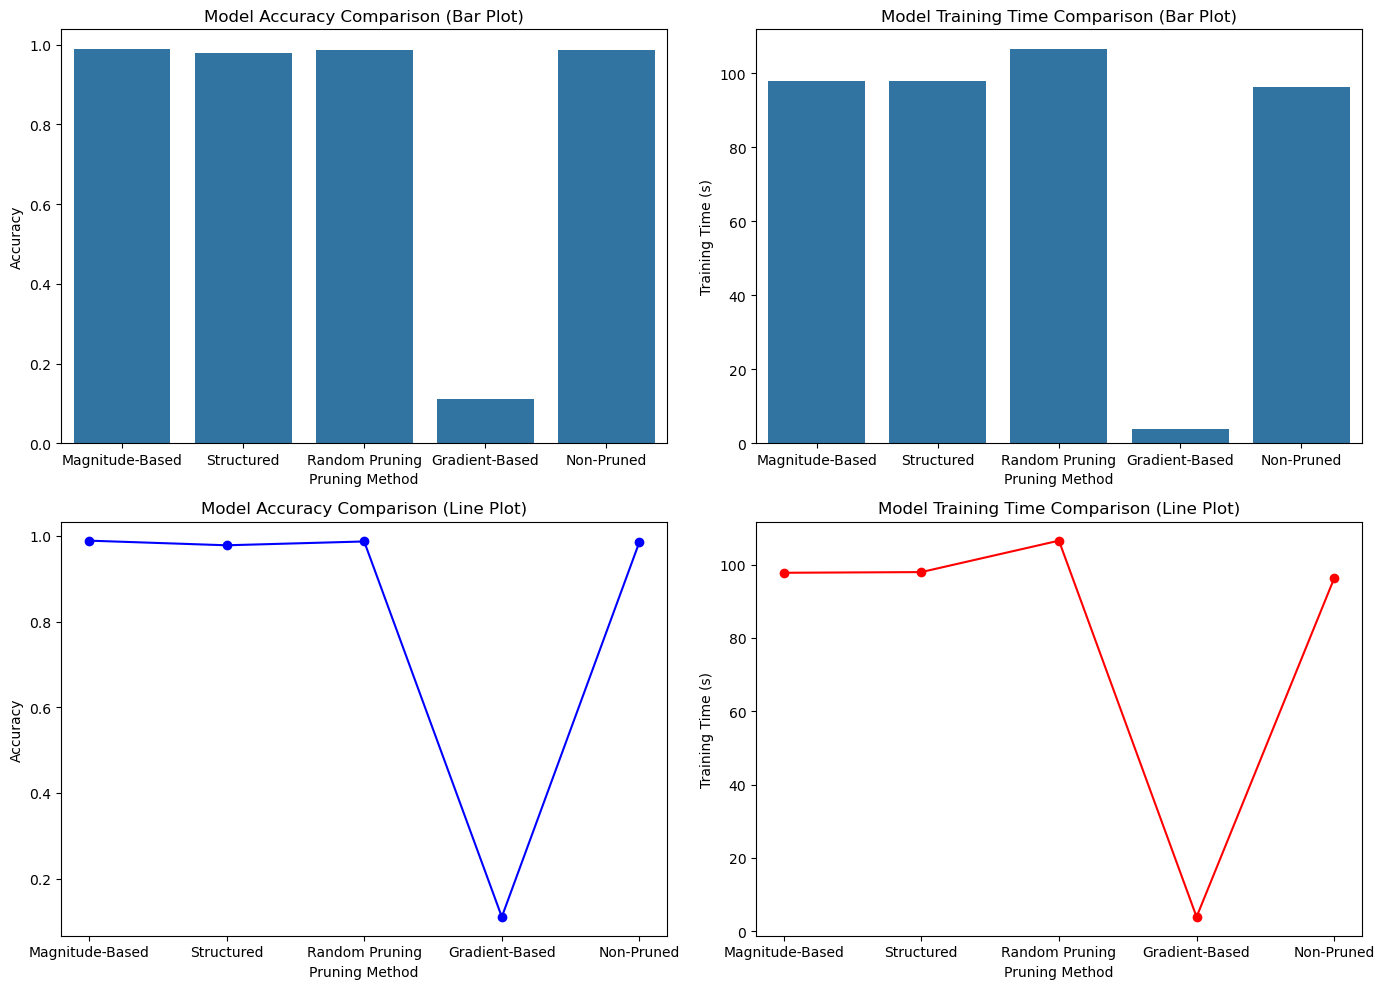

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming pruned_accuracies and pruned_times are dictionaries with pruning results
# and non_pruned_accuracies and non_pruned_times are lists of results for the non-pruned model

# Create a DataFrame with the comparison data
comparison_data = {
    "Pruning Method": ["Magnitude-Based", "Structured", "Random Pruning", "Gradient-Based", "Non-Pruned"],
    "Accuracy": [np.mean(pruned_accuracies["Magnitude-Based"]),
                 np.mean(pruned_accuracies["Structured"]),
                 np.mean(pruned_accuracies["Random"]),
                 np.mean(pruned_accuracies["Gradient-Based"]),
                 np.mean(non_pruned_accuracies)],
    "Training Time (s)": [np.mean(pruned_times["Magnitude-Based"]),
                          np.mean(pruned_times["Structured"]),
                          np.mean(pruned_times["Random"]),
                          np.mean(pruned_times["Gradient-Based"]),
                          np.mean(non_pruned_times)],
}

# Create the DataFrame
df_comparison = pd.DataFrame(comparison_data)

# Set the figure size for the plots
plt.figure(figsize=(12, 6))

# Create a subplot with 2 rows and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Bar plot for Accuracy
sns.barplot(x="Pruning Method", y="Accuracy", data=df_comparison, ax=axes[0, 0])
axes[0, 0].set_title('Model Accuracy Comparison (Bar Plot)')
axes[0, 0].set_xlabel('Pruning Method')
axes[0, 0].set_ylabel('Accuracy')

# Bar plot for Training Time
sns.barplot(x="Pruning Method", y="Training Time (s)", data=df_comparison, ax=axes[0, 1])
axes[0, 1].set_title('Model Training Time Comparison (Bar Plot)')
axes[0, 1].set_xlabel('Pruning Method')
axes[0, 1].set_ylabel('Training Time (s)')

# Line plot for Accuracy
axes[1, 0].plot(df_comparison["Pruning Method"], df_comparison["Accuracy"], marker='o', linestyle='-', color='b')
axes[1, 0].set_title('Model Accuracy Comparison (Line Plot)')
axes[1, 0].set_xlabel('Pruning Method')
axes[1, 0].set_ylabel('Accuracy')

# Line plot for Training Time
axes[1, 1].plot(df_comparison["Pruning Method"], df_comparison["Training Time (s)"], marker='o', linestyle='-', color='r')
axes[1, 1].set_title('Model Training Time Comparison (Line Plot)')
axes[1, 1].set_xlabel('Pruning Method')
axes[1, 1].set_ylabel('Training Time (s)')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()